DBSCAN

In [1]:
import pandas as pd
from utils.cluster import reassign_clusters, cluster, vectorize, tokenize,Cluster

datasets = ['BGL', 'HDFS', 'Linux', 'HealthApp', 'OpenStack', 'OpenSSH', 'Proxifier', 'HPC', 'Zookeeper', 'Mac', 'Hadoop', 'Android', 'Windows', 'Apache', 'Thunderbird', 'Spark']
dataset = 'Linux'
print('-' * 50)
print(f'Clustering {dataset} dataset...')

# load the dataset
# df = pd.read_csv(f'dataset/{dataset}/{dataset}_2k.log_structured_corrected.csv')
df = pd.read_csv(f'dataset/{dataset}/{dataset}_2k.log_structured_corrected.csv')
logs = df['Content'].tolist()[:2000]
templates = df['EventTemplate'].tolist()[:2000]

# tokenize -> vectorize -> cluster -> reassign_clusters
tokenized_logs = [tokenize(log) for log in logs]
labels, cluster_nums = cluster(vectorize(tokenized_logs))
labels, cluster_nums = reassign_clusters(labels, cluster_nums, tokenized_logs)

--------------------------------------------------
Clustering Linux dataset...


Show Clusters

In [5]:
print('num of clusters:', cluster_nums)
print('len of templates:', len(set(templates)))

# store the logs in the cluster
inputs = []
for i in range(cluster_nums):
    inputs.append([-1, [], [], '']) # label, logs, indexs, ground_truth
for i, label in enumerate(labels):
    inputs[label][0] = label
    inputs[label][1].append(logs[i])
    inputs[label][2].append(i)
    if inputs[label][3] == '':
        inputs[label][3] = df['EventTemplate'][i]

clusters = []
for input in inputs:
    c = Cluster(*input, remove_duplicate= True)
    clusters.append(c)
clusters = sorted(clusters, key=lambda cluster: len(cluster.indexs), reverse=True)
num = 3
print('cluster:', num)
print('length:', len(clusters[num].indexs))
print('template:', clusters[num].oracle_template)
set_logs = set(clusters[num].static_logs)
print('len of set:', len(set_logs))
print('-'*20)
for log in set_logs:
    print(log)
print('='*40)

# 269 + 235

num of clusters: 135
len of templates: 115
cluster: 3
length: 118
template: authentication failure; logname= uid=<*> euid=<*> tty=NODEVssh ruser= rhost=<*>
len of set: 16
--------------------
authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=061092085098.ctinets.com
authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=218.55.234.102
authentication failure; logname= uid=0 euid=0 tty=:0 ruser= rhost=
authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=zummit.com
authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=biblioteka.wsi.edu.pl
authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=c9063558.virtua.com.br
authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=211.115.206.155
authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=adsl-70-242-75-179.dsl.ksc2mo.swbell.net
authentication failure; logname= uid=0 euid=0 tty=NODEVssh ruser= rhost=218.188.2.4


Evaluate

In [3]:
from utils.evaluator import evaluate_all_datasets
from IPython.display import HTML
# for i in [5,10,15,20]:
theme = f'DivLog_0shot_32candidate'
table = evaluate_all_datasets(theme)
# HTML(table)

        HDFS: Group Accuracy: 0.9300, Message-Level Accuracy: 0.9955, Edit Distance: 0.0495, Normalized Edit Distance: 0.9989
      Hadoop: Group Accuracy: 0.6825, Message-Level Accuracy: 0.7440, Edit Distance: 6.0375, Normalized Edit Distance: 0.9152
       Spark: Group Accuracy: 0.7375, Message-Level Accuracy: 0.9595, Edit Distance: 1.0480, Normalized Edit Distance: 0.9829
   Zookeeper: Group Accuracy: 0.9550, Message-Level Accuracy: 0.9790, Edit Distance: 0.0790, Normalized Edit Distance: 0.9980
         BGL: Group Accuracy: 0.7360, Message-Level Accuracy: 0.9495, Edit Distance: 1.0310, Normalized Edit Distance: 0.9904
         HPC: Group Accuracy: 0.9350, Message-Level Accuracy: 0.9795, Edit Distance: 0.2025, Normalized Edit Distance: 0.9971
 Thunderbird: Group Accuracy: 0.2340, Message-Level Accuracy: 0.8790, Edit Distance: 1.2360, Normalized Edit Distance: 0.9777
     Windows: Group Accuracy: 0.7100, Message-Level Accuracy: 0.7150, Edit Distance: 13.7175, Normalized Edit Distance

Invocation Test

In [46]:
from openai import OpenAI
from together import Together
import httpx
import openai
import backoff
from utils.postprocess import post_process

api_key = "sk-proj-5EkdZfTfjJ1GJim17pgQT3BlbkFJHCMqWAOX7dTSGOcFOjrn"
client = OpenAI(
    api_key=api_key,                      # api_key
    http_client=httpx.Client(
        proxies="http://127.0.0.1:7890"  # proxies
    ),
)

# api_key = "3e0eca67e7a8720908ba848545b9175f556a6ab6dfc0b63ee3639f9d71e1bbeb"
# client = Together(
#     api_key=api_key,                      # api_key
# )


@backoff.on_exception(backoff.expo, (openai.APIStatusError, openai.InternalServerError), max_tries=20)
def get_responce(messages):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=messages,
        temperature=0.0,
    )
    print(f"model: {response.model}")
    print(f"usage: {response.usage}")
    return response.choices[0].message.content.strip('\n')


output = get_responce([
    {
        "role": "system",
        "content": "You will be provided with some log messages separated by line break. You must abstract variables with `{{placeholders}}` to extract the corresponding template. There might be no variables in the log message.\nPrint the input log's template delimited by backticks."
    },
    {
        "role": "user",
        "content": "proxy.cse.cuhk.edu.hk:5070 close, 1143 bytes (1.11 KB) sent, 365 bytes received, lifetime 00:01\nuser-images.githubusercontent.com:443 close, 335 bytes sent, 4369 bytes (4.26 KB) received, lifetime 03:15\np2.qhimg.com:80 close, 230 bytes sent, 1125 bytes (1.09 KB) received, lifetime 00:09\ndslb.cdn.krcom.cn:80 close, 446 bytes sent, 195160 bytes (190 KB) received, lifetime 00:59\nqa.sockets.stackexchange.com:443 close, 1603 bytes (1.56 KB) sent, 527 bytes received, lifetime 22:32\n13.client-channel.google.com:443 close, 474 bytes sent, 4464 bytes (4.35 KB) received, lifetime 01:30\nf-log-extension.grammarly.io:443 close, 643 bytes sent, 3276 bytes (3.19 KB) received, lifetime 00:19\nlong.open.weixin.qq.com:443 close, 1910 bytes (1.86 KB) sent, 276 bytes received, lifetime 00:28\nstatic.doubleclick.net:443 close, 2553 bytes (2.49 KB) sent, 641 bytes received, lifetime 06:39\nzhihu-web-analytics.zhihu.com:443 close, 343 bytes sent, 3122 bytes (3.04 KB) received, lifetime 00:17"
    }
])
print(output)

model: gpt-3.5-turbo-0125
usage: CompletionUsage(completion_tokens=43, prompt_tokens=391, total_tokens=434)
`{{host}}:{{port}} close, {{sent_bytes}} bytes ({{sent_kb}} KB) sent, {{received_bytes}} bytes ({{received_kb}} KB) received, lifetime {{duration}}`


Check out some strings' freq in the whole logs or templates

In [2]:
import pandas as pd

datasets = ['BGL', 'HDFS', 'Linux', 'HealthApp', 'OpenStack', 'OpenSSH', 'HPC', 'Zookeeper', 'Mac', 'Hadoop', 'Android', 'Windows', 'Apache', 'Thunderbird', 'Spark']

count = 0
count_templates = []
count_varaibles = {}
for dataset in datasets:
    print(f"Processing {dataset} ----------------")
    df = pd.read_csv(f'dataset/{dataset}/{dataset}_2k.log_structured_corrected.csv')
    logs = df['Content'].tolist()
    templates = df['EventTemplate'].tolist()
    for log, template in zip(logs, templates):
        if '<*> <*>' in template and template not in count_templates:
            count_templates.append(template)
            print(template)
            print(log)
            print('-'*20)



# print(count_varaibles)
# for key in count_varaibles:
#     count += count_varaibles[key]
# for i in range(100):
#     if count_varaibles.get(i):
#         print(f"Number of templates with {i} variables: {count_varaibles[i]}")
# print((4131+9825+7200+3700+2304+591) / 30000)
# print((4131+9825+7200+3700+2304+591 + 563 + 1133 + 52 + 16 + 35) / 30000)

Processing BGL ----------------
ciod: In packet from node <*> (<*>), message code <*> is not <*> or <*> (softheader=<*> <*> <*> <*>)
ciod: In packet from node 91.0 (R62-M1-Nf-C:J03-U11), message code 2 is not 3 or 4294967295 (softheader=003b005b 00030000 00000001 00000000)
--------------------
rts: bad message header: expecting type <*> instead of type <*> (softheader=<*> <*> <*> <*>) PSR0=<*> PSR1=<*> PRXF=<*> PIXF=<*>
rts: bad message header: expecting type 57 instead of type 3 (softheader=00131db8 81aa0003 00000002 00000000) PSR0=00001f01 PSR1=00000000 PRXF=00000002 PIXF=00000007
--------------------
Error receiving packet on tree network, expecting type <*> instead of type <*> (softheader=<*> <*> <*> <*>) PSR0=<*> PSR1=<*> PRXF=<*> PIXF=<*>
Error receiving packet on tree network, expecting type 57 instead of type 3 (softheader=0064588e 8aff0003 00000002 00000000) PSR0=00001f01 PSR1=00000000 PRXF=00000002 PIXF=00000007
--------------------
Processing HDFS ----------------
BLOCK* Nam

## sample based on entropy

In [ ]:
from utils.sample import sample_based_on_entropy

# datasets = ['BGL', 'HDFS', 'Linux', 'HealthApp', 'OpenStack', 'OpenSSH', 'Proxifier', 'HPC', 'Zookeeper', 'Mac',
#         'Hadoop', 'Android', 'Windows', 'Apache', 'Thunderbird', 'Spark']
# for dataset in datasets:
#     pair = sample_based_on_entropy(dataset, 1)
#     print(pair[0][0])
dataset = 'HDFS'
pairs = sample_based_on_entropy(dataset, 1)
for pair in pairs:
    print(f"{pair[0][0]}\n{pair[0][1]}\n{'-'*20}")

## Caculate Cost

In [ ]:
import json
from utils.util import count_message_tokens, count_message_variables


table_order = 'HDFS Hadoop Spark Zookeeper BGL HPC Thunderbird Windows Linux Android HealthApp Apache OpenSSH OpenStack Mac'
datasets = table_order.split(' ')
logs = {}
counts_token = {}
counts_message = {}
for dataset in datasets:
    df = pd.read_csv(f'dataset/{dataset}/{dataset}_2k.log_structured_corrected.csv')
    logs[dataset] = df['Content'].tolist()
    counts_token[dataset] = 0
    counts_message[dataset] = 0
for log in logs['HealthApp']:
    log = log.strip()

# 存储解析后的日志列表
message_list = []
# load every message
file = 'cost_lilac_32_3.json'
with open('outputs/cost/LogBatcher_3shot_32candidate_10batchsize.json', 'r') as file:
    for line in file:
        if line.strip() == '[':
            list_str = ''
            start_load = True
        if line.strip() == ']':
            list_str += line
            message = json.loads(list_str)
            message_list.append(message)
            start_load = False
        if start_load:
            list_str += line
# print(len(message_list))
for message in message_list:
    # for LILAC
    log = message[-1]['content'].split('\n')[0].replace('Log message: `', '').replace('`', '')
    # for LogBatcher
    # log = message[-1]['content'].split('\n')[0] 
    # print(log)
    for dataset in datasets:
        if log in logs[dataset]:
            counts_token[dataset] += count_message_tokens(message, 'gpt-3.5-turbo')
            counts_message[dataset] += 1
            break
        if dataset == 'Mac':
            print(log)
for dataset in datasets:
    print(counts_token[dataset], counts_token[dataset] / counts_message[dataset]  )

print(sum(counts_token.values()), sum(counts_token.values()) / sum(counts_message.values()))

# remove the same log messages

# def make_hashable(log_list):

#     return tuple(tuple(sorted(d.items())) for d in log_list)
# unique_lists = list(set(make_hashable(log_list) for log_list in message_list))

# unique_big_list = [list(map(dict, log_list)) for log_list in unique_lists]
# print(len(unique_big_list))

Unseen logs

In [ ]:
from collections import Counter
import os
import pandas as pd
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cosine
import numpy as np

table_order = 'HDFS Hadoop Spark Zookeeper BGL HPC Thunderbird Windows Linux Android HealthApp Apache OpenSSH OpenStack Mac'
datasets = table_order.split(' ')
a = 0
b = 0
for dataset in datasets:

    file = 'Test_10shot'
    groundtruth_file = f'dataset/{dataset}/{dataset}_2k.log_structured_corrected.csv'
    output_file = f'outputs/parser/{file}/{dataset}_2k.log_structured.csv'

    templates_groundtruth = pd.read_csv(groundtruth_file)[
        'EventTemplate'].tolist()
    templates_output = pd.read_csv(output_file)['EventTemplate'].tolist()

    freq = Counter(templates_groundtruth)
    unseen_templates = [item for item, count in freq.items() if count == 1]

    indexes = []
    for index, template in enumerate(templates_groundtruth):
        if template in unseen_templates:
            indexes.append(index)

    accuracy_exact_string_matching = accuracy_score([templates_groundtruth[index] for index in indexes], [
                                                    templates_output[index] for index in indexes], normalize=False)
    length = len(indexes)
    a += length
    b += accuracy_exact_string_matching
    dataset = ' ' * (12 - len(dataset)) + dataset
    print('%s: len of unseen log: %.4d, Message-Level Accuracy: %.4f' %
          (dataset, length, accuracy_exact_string_matching/length))


print(b/a)
print(a/len(datasets))
# 81.0 71.2

Data load
main result

In [4]:
c = '''0.998 	0.999 	0.999 	0.998 	0.999 	0.999 	0.998 	0.959 	0.997 	0.930 	0.961 	0.993 	0.930 	0.996 	0.999 	1.000 	1.000 	1.000 	1.000 	1.000 	1.000 
0.948 	0.613 	0.882 	0.869 	0.606 	0.901 	0.950 	0.158 	0.751 	0.694 	0.195 	0.708 	0.683 	0.744 	0.915 	0.991 	0.958 	0.986 	0.990 	0.886 	0.952 
0.920 	0.398 	0.963 	0.905 	0.398 	0.952 	0.998 	0.376 	0.950 	0.470 	0.296 	0.915 	0.738 	0.960 	0.983 	0.999 	0.983 	0.998 	0.998 	0.972 	0.989 
0.967 	0.799 	0.981 	0.965 	0.800 	0.981 	0.989 	0.779 	0.987 	0.956 	0.805 	0.970 	0.955 	0.979 	0.998 	1.000 	0.987 	0.999 	0.995 	0.988 	0.995 
0.963 	0.479 	0.885 	0.957 	0.474 	0.883 	0.996 	0.426 	0.891 	0.702 	0.282 	0.785 	0.736 	0.950 	0.990 	0.983 	0.972 	0.989 	0.987 	0.941 	0.989 
0.887 	0.662 	0.872 	0.904 	0.680 	0.880 	0.945 	0.660 	0.973 	0.978 	0.751 	0.870 	0.935 	0.980 	0.997 	0.970 	0.994 	0.999 	0.953 	0.943 	0.995 
0.957 	0.180 	0.941 	0.945 	0.180 	0.943 	0.971 	0.060 	0.932 	0.554 	0.097 	0.826 	0.234 	0.879 	0.978 	0.984 	0.913 	0.983 	0.914 	0.854 	0.953 
0.997 	0.466 	0.948 	0.691 	0.158 	0.840 	0.997 	0.463 	0.976 	0.694 	0.141 	0.915 	0.710 	0.715 	0.903 	0.696 	0.685 	0.897 	1.000 	0.609 	0.862 
0.422 	0.217 	0.750 	0.405 	0.205 	0.745 	0.358 	0.176 	0.770 	0.186 	0.125 	0.684 	0.484 	0.620 	0.935 	0.298 	0.422 	0.926 	0.998 	0.976 	0.992 
0.885 	0.750 	0.972 	0.773 	0.540 	0.876 	0.960 	0.253 	0.924 	0.795 	0.436 	0.822 	0.737 	0.677 	0.952 	0.953 	0.627 	0.923 	0.971 	0.787 	0.953 
0.901 	0.375 	0.749 	0.893 	0.368 	0.744 	1.000 	0.261 	0.871 	0.833 	0.677 	0.850 	0.876 	0.984 	0.997 	0.998 	0.988 	0.998 	0.920 	0.914 	0.961 
1.000 	0.978 	0.996 	1.000 	0.978 	0.996 	1.000 	0.984 	0.996 	1.000 	0.972 	0.995 	0.984 	0.985 	0.997 	1.000 	1.000 	1.000 	1.000 	0.978 	0.996 
0.527 	0.644 	0.938 	0.504 	0.630 	0.965 	0.527 	0.655 	0.938 	0.838 	0.477 	0.816 	0.559 	0.993 	0.999 	1.000 	0.995 	0.999 	1.000 	0.986 	0.997 
0.789 	0.594 	0.919 	0.547 	0.729 	0.965 	1.000 	0.287 	0.948 	0.802 	0.928 	0.960 	0.749 	0.987 	0.999 	0.753 	0.805 	0.983 	1.000 	0.976 	0.989 
0.224 	0.105 	0.693 	0.249 	0.034 	0.718 	0.492 	0.112 	0.937 	0.315 	0.071 	0.724 	0.220 	0.437 	0.873 	1.000 	0.977 	0.991 	1.000 	0.982 	0.995 
0.814 	0.392 	0.896 	0.765 	0.284 	0.835 	0.949 	0.383 	0.902 	0.759 	0.359 	0.843 	0.712 	0.549 	0.898 	0.805 	0.562 	0.892 	0.831 	0.528 	0.879 
0.825 	0.541 	0.899 	0.773 	0.504 	0.889 	0.883 	0.437 	0.921 	0.719 	0.473 	0.855 	0.702 	0.839 	0.963 	0.902 	0.867 	0.973 	0.972 	0.895 	0.969'''



# count baseline num

num = int(len(c.split('\n')[0].split('\t')) / 3)

GA, MLA, ED = [], [], []

for i in range(num):

    GA.append([])

    MLA.append([])

    ED.append([])



lines = c.split('\n')

for line in lines:

    num_list = line.split('\t')

    for i in range(num):

        GA[i].append(float(num_list[i*3]))

        MLA[i].append(float(num_list[i*3 + 1]))

        ED[i].append(float(num_list[i*3 + 2]))

Robust

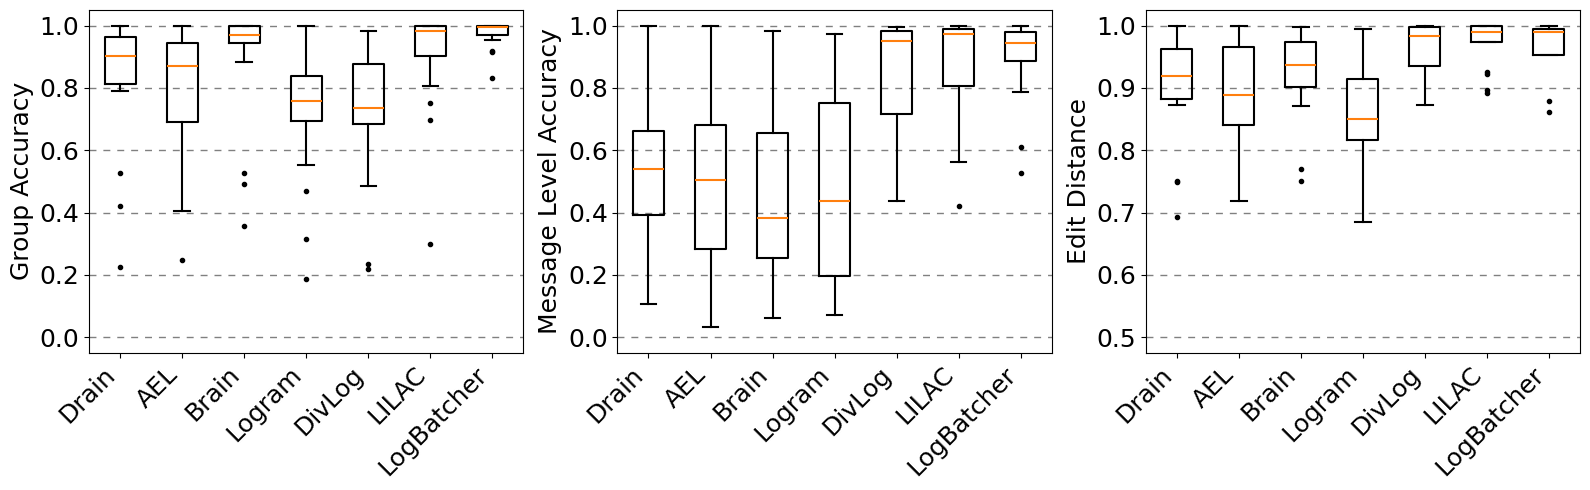

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    'Log Parser': ['Drain', 'AEL', 'Brain', 'Logram', 'DivLog', 'LILAC', 'LogBatcher'],
    'Group Accuracy': GA,
    'Message Level Accuracy': MLA,
    'Edit Distance': ED
}

# 将数据转换为DataFrame
df = pd.DataFrame(data)
flierprops = dict(marker='o', color='black', markersize=3,
                  markerfacecolor='black', markeredgecolor='black')
# 绘制箱线图
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

label_fontsize = 18
x_fontsize = 18
y_fontsize = 18
special_tick_fontsize = 16  # 特定指标的字体大小
space_size = 0.05
line_size = dict(linewidth=1.5)

for ax in axs[:2]:
    for i in [0, 0.2, 0.4, 0.6, 0.8, 1.0]:
        ax.axhline(y=i, color='gray', linestyle='--',
                   linewidth=1, dashes=(5, 5))
    ax.tick_params(axis='y', labelsize=y_fontsize)

for i in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    axs[2].axhline(y=i, color='gray', linestyle='--',
                   linewidth=1, dashes=(5, 5))
# Adjust y-axis label font siz
axs[2].tick_params(axis='y', labelsize=y_fontsize)
# Group Accuracy
axs[0].boxplot(df['Group Accuracy'], labels=df['Log Parser'], boxprops=line_size, capprops=line_size,
               whiskerprops=line_size, medianprops=line_size,
               flierprops=flierprops)
axs[0].set_ylabel('Group Accuracy', rotation=90, fontsize=label_fontsize)
axs[0].set_ylim(0-space_size, 1+space_size)
axs[0].set_xticklabels(df['Log Parser'], rotation=45,
                       ha='right', fontsize=x_fontsize)


# Parsing Accuracy
axs[1].boxplot(df['Message Level Accuracy'], boxprops=line_size, capprops=line_size,
               whiskerprops=line_size, medianprops=line_size,
               labels=df['Log Parser'], flierprops=flierprops)
axs[1].set_ylabel('Message Level Accuracy',
                  rotation=90, fontsize=label_fontsize)
axs[1].set_ylim(0-space_size, 1+space_size)
axs[1].set_xticklabels(df['Log Parser'], rotation=45,
                       ha='right', fontsize=x_fontsize)

# Edit Distance
axs[2].boxplot(df['Edit Distance'], boxprops=line_size, capprops=line_size,
               whiskerprops=line_size, medianprops=line_size,
               labels=df['Log Parser'], flierprops=flierprops)
axs[2].set_ylabel('Edit Distance', rotation=90, fontsize=label_fontsize)
axs[2].set_ylim(0.5 - space_size/2, 1 + space_size/2)
axs[2].set_xticklabels(df['Log Parser'], rotation=45,
                       ha='right', fontsize=x_fontsize)

plt.tight_layout()

# 保存为 PDF 文件
plt.savefig('outputs/figures/RQ1_Robust.pdf', format='pdf')

plt.show()

In [3]:
results = {}
for metric in ['Group Accuracy', 'Message Level Accuracy', 'Edit Distance']:
    print(f"\n{metric} Statistics:")
    for log_parser, values in zip(data['Log Parser'], data[metric]):
        median = np.median(values)
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        min_val = np.min(values)
        max_val = np.max(values)
        print(f"{log_parser}: Median={median}, Q1={q1}, Q3={q3}, Min={min_val}, Max={max_val}")


Group Accuracy Statistics:
Drain: Median=0.9105000000000001, Q1=0.8372499999999999, Q3=0.964, Min=0.224, Max=1.0
AEL: Median=0.881, Q1=0.7464999999999999, Q3=0.948, Min=0.249, Max=1.0
Brain: Median=0.98, Q1=0.948, Q3=0.998, Min=0.358, Max=1.0
Logram: Median=0.735, Q1=0.659, Q3=0.85725, Min=0.186, Max=1.0
DivLog: Median=0.7364999999999999, Q1=0.7032499999999999, Q3=0.8895, Min=0.22, Max=0.984
LILAC: Median=0.9835, Q1=0.8725, Q3=0.99925, Min=0.298, Max=1.0
LogBatcher: Median=0.9924999999999999, Q1=0.96575, Q3=1.0, Min=0.831, Max=1.0

Message Level Accuracy Statistics:
Drain: Median=0.5065, Q1=0.38775000000000004, Q3=0.684, Min=0.105, Max=0.999
AEL: Median=0.4845, Q1=0.26425, Q3=0.69225, Min=0.034, Max=0.999
Brain: Median=0.3795, Q1=0.23375, Q3=0.51225, Min=0.06, Max=0.984
Logram: Median=0.39749999999999996, Q1=0.1815, Q3=0.7645, Min=0.071, Max=0.972
DivLog: Median=0.9145, Q1=0.7055, Q3=0.981, Min=0.437, Max=0.996
LILAC: Median=0.965, Q1=0.775, Q3=0.98725, Min=0.422, Max=1.0
LogBatcher: 

Supervised Figures

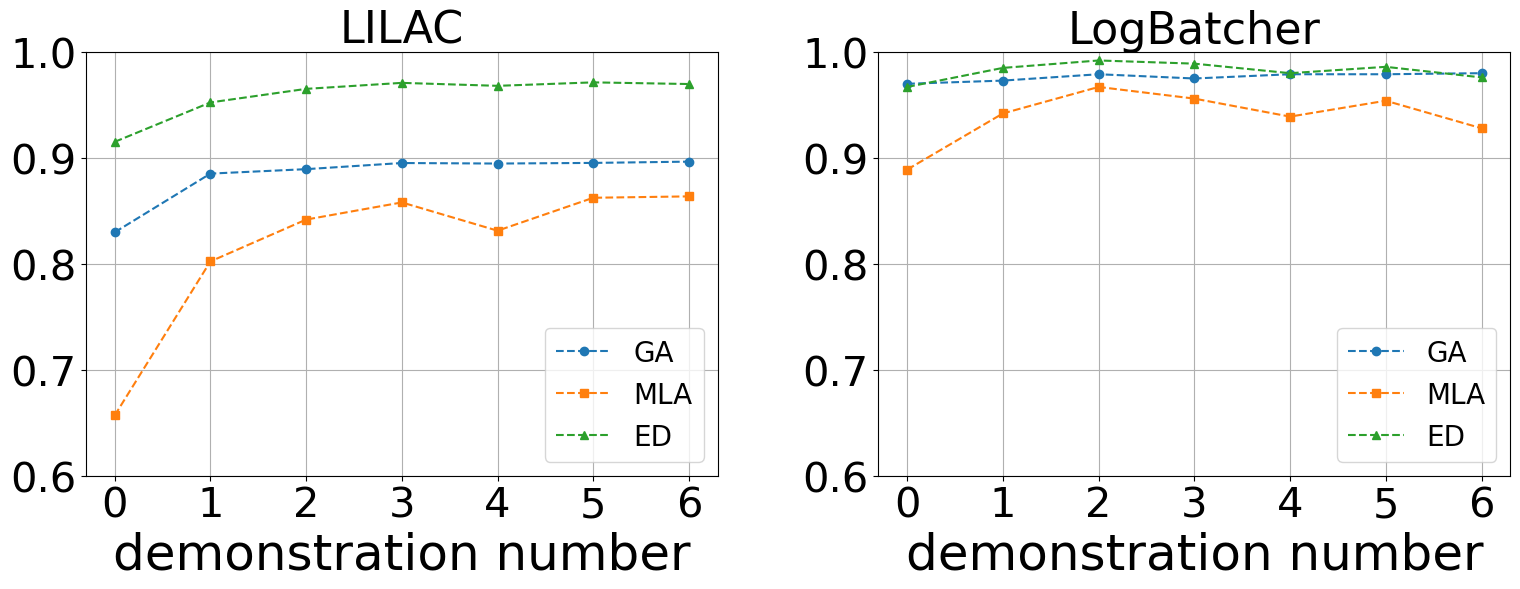

In [7]:
import matplotlib.pyplot as plt

# Load data

# LILAC
data1 = '''0.8298 0.6569 0.91518
0.8852 0.8023 0.95239
0.8894 0.8418 0.9652
0.8952 0.858 0.97086
0.8947 0.8313 0.96806
0.8953 0.8624 0.97133
0.8965 0.8637 0.96976'''

# LogBatcher
data2 = '''0.970 	0.889 	0.967
0.973 	0.942 	0.985 
0.979 	0.967 	0.992 
0.975 	0.956 	0.989 
0.979 	0.939 	0.980 
0.979 	0.954 	0.986 
0.980 	0.928 	0.976'''

# Function to process data


def process_data(data):
    accuracy_metric1 = []
    accuracy_metric2 = []
    accuracy_metric3 = []

    data_list = data.replace('\t', ' ').replace(
        '\n', ' ').replace('  ', ' ').split()
    for index, data_item in enumerate(data_list):
        if index % 3 == 0:
            accuracy_metric1.append(float(data_item))
        elif index % 3 == 1:
            accuracy_metric2.append(float(data_item))
        else:
            accuracy_metric3.append(float(data_item))

    return accuracy_metric1, accuracy_metric2, accuracy_metric3


# Process the data
accuracy_metric1_data1, accuracy_metric2_data1, accuracy_metric3_data1 = process_data(
    data1)
accuracy_metric1_data2, accuracy_metric2_data2, accuracy_metric3_data2 = process_data(
    data2)

# Data for the plot
shots = [0, 1, 2, 3, 4, 5, 6]

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

font_size = 36
label_size = 30
title_size = 32
legend_size = 20

# Plot data1
ax1.plot(shots, accuracy_metric1_data1, marker='o', linestyle='--', label='GA')
ax1.plot(shots, accuracy_metric2_data1,
         marker='s', linestyle='--', label='MLA')
ax1.plot(shots, accuracy_metric3_data1,
         marker='^', linestyle='--', label='ED')
ax1.set_xlabel('demonstration number', fontsize=font_size)
ax1.set_xticks(shots)
ax1.set_yticks([i/10 for i in range(5, 11)])
ax1.set_ylim(0.6, 1)
ax1.legend(loc='lower right', prop={'size': 20})
ax1.grid(True)
ax1.set_title('LILAC', fontsize=title_size)

# Set bold font for tick labels on ax1
plt.setp(ax1.get_xticklabels(), fontsize=label_size)
plt.setp(ax1.get_yticklabels(), fontsize=label_size)

# Plot data2
ax2.plot(shots, accuracy_metric1_data2, marker='o', linestyle='--', label='GA')
ax2.plot(shots, accuracy_metric2_data2,
         marker='s', linestyle='--', label='MLA')
ax2.plot(shots, accuracy_metric3_data2,
         marker='^', linestyle='--', label='ED')
ax2.set_xlabel('demonstration number', fontsize=font_size)
ax2.set_xticks(shots)
ax2.set_yticks([i/10 for i in range(5, 11)])
ax2.set_ylim(0.6, 1)
ax2.legend(loc='lower right', prop={'size': 20})
ax2.grid(True)
ax2.set_title('LogBatcher', fontsize=title_size)

# Set bold font for tick labels on ax2
plt.setp(ax2.get_xticklabels(), fontsize=label_size)
plt.setp(ax2.get_yticklabels(), fontsize=label_size)

# Create a common legend for both plots
# handles, labels = ax1.get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(
#     0.5, 1.15), ncol=3, prop={'size': legend_size})

plt.subplots_adjust(wspace=30)

# Show the plot
plt.tight_layout()
plt.savefig('outputs/figures/RQ3_supervised.pdf')
plt.show()

Ablation: Bacth Size

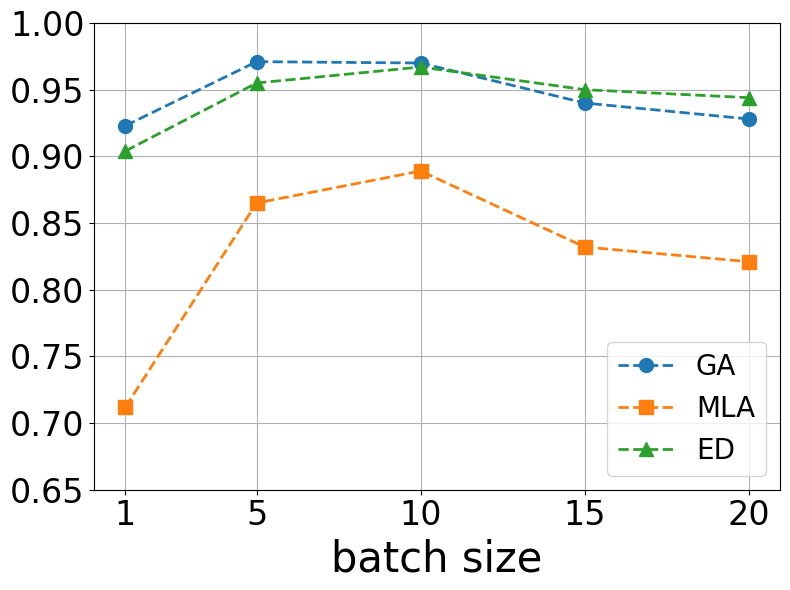

In [11]:
import matplotlib.pyplot as plt

# Define the data
data1 = '''0.923 	0.712 	0.904 
0.971 	0.865 	0.955 
0.970 	0.889 	0.967 
0.940 	0.832 	0.950 
0.928 	0.821 	0.944'''

# Function to process data


def process_data(data):
    accuracy_metric1 = []
    accuracy_metric2 = []
    accuracy_metric3 = []

    data_list = data.replace('\n', ' ').strip().split()
    for index, data_item in enumerate(data_list):
        if index % 3 == 0:
            accuracy_metric1.append(float(data_item))
        elif index % 3 == 1:
            accuracy_metric2.append(float(data_item))
        else:
            accuracy_metric3.append(float(data_item))

    return accuracy_metric1, accuracy_metric2, accuracy_metric3


# Process the data
accuracy_metric1_data1, accuracy_metric2_data1, accuracy_metric3_data1 = process_data(
    data1)

# Data for the plot
shots = [1, 5, 10, 15, 20]

# Create the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

font_size = 30
label_size = 24
title_size = 32

# Plot data1
ax1.plot(shots, accuracy_metric1_data1, marker='o',
         linestyle='--', label='GA', linewidth=2, markersize=10)
ax1.plot(shots, accuracy_metric2_data1, marker='s',
         linestyle='--', label='MLA', linewidth=2, markersize=10)
ax1.plot(shots, accuracy_metric3_data1, marker='^',
         linestyle='--', label='ED', linewidth=2, markersize=10)
ax1.set_xlabel('batch size', fontsize=font_size)
ax1.set_xticks(shots)
ax1.set_yticks([i/100 for i in range(30, 101, 5)])
ax1.set_ylim(0.65, 1)
ax1.legend(loc='lower right', prop={'size': 20})
ax1.grid(True)
# ax1.set_title('LILAC', fontsize=title_size)

# Set bold font for tick labels on ax1
plt.setp(ax1.get_xticklabels(), fontsize=label_size)
plt.setp(ax1.get_yticklabels(), fontsize=label_size)

# Show the plot
plt.tight_layout()
plt.savefig('outputs/figures/RQ2_batchsize.pdf')
plt.show()

In [1]:
import pandas as pd
from tqdm import tqdm
from utils.evaluator import evaluate
dataset = 'BGL'
output_file = 'outputs/parser/LogBatcher_0shot_32candidate_10batchsize_2000chunksize_full/BGL_2k.log_structured.csv'
# output_file ='outputs/parser/LogBatcher_0shot_32candidate_10batchsize/BGL_2k.log_structured.csv'
groundtruth_file = 'dataset/BGL/BGL_full.log_structured.csv'
# groundtruth_file = 'dataset/BGL/BGL_2k.log_structured_corrected.csv'
a =evaluate(output_file=output_file, groundtruth_file=groundtruth_file,dataset=dataset)
print(a)
# df1 = pd.read_csv('outputs/parser/LogBatcher_0shot_32candidate_10batchsize_2000chunksize_full/BGL_2k.log_structured.csv')
# logs1 = df1['EventTemplate'].tolist()
# df2 = pd.read_csv('dataset/BGL/BGL_full.log_structured.csv')
# logs2 = df2['EventTemplate'].tolist()

# count = 0
# length = len(logs1)
# for i in tqdm(range(length)):
#     if logs1[i] == logs2[i]:
#         count += 1
# print(count / length)
# print(count)


MLA:  0.9208615105043745


4631261it [2:18:59, 555.37it/s] 


ED:  3.3680436062661983
NED:  0.977276983555154


100%|██████████| 320/320 [01:31<00:00,  3.51it/s]


PA:  0.9522205723236069
         BGL: group Accuracy: 0.9522, Message-Level Accuracy: 0.9209, Edit Distance: 3.3680, Normalized Edit Distance: 0.977277
(0.9522205723236069, 0.9208615105043745, 3.3680436062661983, 0.977276983555154)


In [ ]:
import pandas as pd
from tqdm import tqdm
from utils.evaluator import evaluate
dataset = 'HDFS'
output_file = f'outputs/parser/LogBatcher_0shot_32candidate_10batchsize_2000chunksize_full/{dataset}_2k.log_structured.csv'
groundtruth_file = f'dataset/{dataset}/{dataset}_full.log_structured.csv'
# a =evaluate(output_file=output_file, groundtruth_file=groundtruth_file,dataset=dataset)
# print(a)
df1 = pd.read_csv(output_file)
logs1 = df1['EventTemplate'].tolist()
df2 = pd.read_csv(groundtruth_file)
logs2 = df2['EventTemplate'].tolist()

count = 0
length = len(logs1)
for i in tqdm(range(length)):
    if logs1[i] == logs2[i]:
        count += 1
print(count / length)
print(count)
